In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def remove_GK(samples):
    kmeans = KMeans(n_clusters=2, random_state=42).fit(samples)
    labels, cnts = np.unique(kmeans.labels_, return_counts=True)
    majLabel = labels[np.argmax(cnts)]
    return np.where(kmeans.labels_ == majLabel)[0]

def group_samples(total_samples, nonGK_ind, nonGK_labels):
    maxLabel = np.amax(nonGK_labels)
    allLabels = np.full((total_samples), maxLabel+1)
    allLabels[nonGK_ind] = nonGK_labels
    return allLabels

In [6]:
df = pd.read_csv("../../datasets/soccer_player_embeddings_feature_no_labels_120K.csv", index_col=0).sample(frac=1)
EMBEDDINGS = "120K_PCA-no-label"
df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,player_fifa_api_id,player_positions,player_positions_general
5306,-0.157770,-0.217141,-0.074926,0.119582,-0.604439,0.235030,0.283937,0.235984,0.552348,-0.083091,-0.183125,0.021513,-0.050113,-0.041444,-0.030519,175866,"CB, RB",DEF
22254,-0.405157,-0.349278,0.696905,-0.352758,-0.154302,0.021357,-0.097894,0.150029,-0.072190,-0.120491,0.037144,0.141829,-0.020354,0.055572,-0.051516,193705,"ST, CF",ATK
59748,-0.305731,-0.287078,0.383117,0.037618,-0.640256,0.076865,0.148176,-0.088043,-0.233631,-0.100165,-0.029357,-0.008630,0.240522,-0.249664,-0.211283,199307,"RB, RM",DEF
44497,-0.171527,-0.372300,-0.530163,0.593612,0.251421,-0.128967,-0.225369,-0.046336,-0.053766,-0.109994,0.005728,0.006362,-0.219568,-0.038507,0.031389,212800,"CDM, CM",MID
114317,-0.382669,-0.262493,0.631836,-0.357748,-0.106782,0.078427,-0.307883,-0.029551,0.107882,0.111208,0.174445,-0.178606,0.171515,-0.013517,0.168245,254416,LW,ATK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70923,-0.402462,0.780311,-0.180623,-0.136821,0.086473,-0.243604,0.115147,-0.053233,0.141045,-0.097849,0.178889,-0.170017,0.047264,0.038682,0.027852,221791,LM,MID
117703,-0.185944,-0.262229,-0.102693,-0.093978,0.735911,0.330344,0.113771,-0.194326,0.110110,0.242198,0.161535,0.151091,0.117971,-0.159824,0.129298,233175,"CAM, LM, RM",MID
11299,-0.316705,-0.339943,-0.473301,0.437200,0.338570,-0.171329,-0.227102,-0.107151,0.071792,-0.263074,0.168600,-0.023291,0.054678,-0.171917,0.161442,175563,"RM, CAM",MID
21678,-0.125034,0.861658,-0.297537,0.130809,-0.195646,0.039964,0.168206,-0.039953,-0.110888,-0.153295,-0.089269,-0.138762,-0.053219,0.003313,0.025435,222151,CB,DEF


In [7]:
X = df.iloc[:, :15].values
train_X = X[:-100]
print(train_X.shape)
test_X = X[-100:]
print(test_X.shape)

(121309, 15)
(100, 15)


In [15]:
nonGK_ind = remove_GK(train_X)
subset_train_X = train_X[nonGK_ind]

In [4]:
y = df['player_positions']

In [5]:
labels = []
for l in y.values:
    if ',' in l:
        labels.extend(l.split(", "))
    else:
        labels.append(l)

labels, counts = np.unique(labels, return_counts=True)
for i, l in enumerate(labels):
    print("Position: {}, count {}".format(l, counts[i]))

Position: CAM, count 887
Position: CB, count 1326
Position: CDM, count 1098
Position: CF, count 229
Position: CM, count 1326
Position: GK, count 561
Position: LB, count 754
Position: LM, count 906
Position: LW, count 357
Position: LWB, count 44
Position: RB, count 779
Position: RM, count 918
Position: RW, count 390
Position: RWB, count 29
Position: ST, count 1157


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(5086, 14)
(1272, 14)


# Clustering Evaluation

In [10]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.cm as cm

In [11]:
def silhouette_blob(samples, cluster_labels, cluster_centres=None, title=None, save_link=None):
    n_clusters = len(np.unique(cluster_labels))
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(samples) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(samples, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(samples, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(samples[:, 0], samples[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        if cluster_centres is not None:
            # Draw white circles at cluster centers
            ax2.scatter(cluster_centres[:, 0], cluster_centres[:, 1], marker='o',
                        c="white", alpha=1, s=200, edgecolor='k')

            for i, c in enumerate(cluster_centres):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                            s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for %s" % (title)),
                     fontsize=14, fontweight='bold')
    
    if save_link:
        plt.savefig('{}/{} Silhouette Scores.png'.format(save_link, title))
    plt.show()
    
    return silhouette_avg

In [12]:
def labels_in_cluster(given_cluster, num_clusters, title=None, save_link=None):
    y_train_vals = y_train.values
    classes_in_cluster = np.zeros(shape=(num_clusters, len(labels)), dtype=int)
    for i in range(num_clusters):
        dataInd = np.argwhere(given_cluster==i).flatten()
        for ind in dataInd:
            if ',' in y_train_vals[ind]:
                split = y_train_vals[ind].split(', ')
                for s in split:
                    j, = np.where(labels == s)
                    classes_in_cluster[i][j] += 1
            else:
                j, = np.where(labels == y_train_vals[ind])
                classes_in_cluster[i][j] += 1
    
    plt.figure(figsize=(15,5))
    if title:
        plt.title("Labels within clusters by {}".format(title))
    else:
        plt.title("Labels within clusters")
    sns.heatmap(classes_in_cluster, annot=True, cmap='Blues', fmt="d")
    plt.xticks([(i+0.5) for i in np.arange(len(labels))], labels=labels)
    
    if save_link:
        plt.savefig('{}/{} Labels within Clusters.png'.format(save_link, title))
    plt.show()

In [13]:
def cosine_matrix(samples, labels, title=None, save_link=None):
    unique_labels, counts = np.unique(labels, return_counts=True)
    tick_loc = [(sum(counts[:i])+counts[i]/2) for i in np.arange(len(unique_labels))]
    
    num_samples = samples.shape[0]
    sortedInd = np.argsort(labels)
    
    plt.figure(figsize=(20,15))
    if title:
        plt.title("Cosine Matrix by Clusters from {}".format(title))
    else:
        plt.title("Cosine Matrix by Clusters")
    sns.heatmap(cosine_similarity(samples[sortedInd]), cmap='Blues')
    plt.yticks(tick_loc, labels=unique_labels)
    plt.xticks(tick_loc, labels=unique_labels, rotation='horizontal')
    
    if save_link:
        plt.savefig('{}/{} Cosine Similarity.png'.format(save_link, title))
    plt.show()

In [ ]:
cosine_matrix(X_train.values, kmeans.labels_)

# Clustering Techniques

## KMeans

In [14]:
from sklearn.cluster import KMeans

In [ ]:
kMeans_df = pd.DataFrame(columns=['Algorithm', 'Embeddings', 'Num Clusters', 'Silhouette Score'])

In [ ]:
for nc in range(6,21,2):
    title = "kMeans {} clusters".format(nc)
    kmeans = KMeans(n_clusters=nc, random_state=42).fit(X_train)
    score = silhouette_blob(X_train.values, kmeans.labels_, kmeans.cluster_centers_, title, save_link)
    kMeans_df = kMeans_df.append({'Algorithm' : 'KMeans', 'Embeddings' : EMBEDDINGS, 'Num Clusters' : nc, 'Silhouette Score' : score},  
                ignore_index = True) 
    cosine_matrix(X_train.values, kmeans.labels_, title, save_link)

In [ ]:
kMeans_df

In [ ]:
kMeans_df.to_csv('{}/results.csv'.format(save_link))

## Agglomerative Clustering

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [29]:
def find_elbow(linkageArr, startSearch=1, title=None):
    last = linkageArr[-30:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    acceleration = np.diff(last, 2)  # 2nd derivative of the distances
    acceleration_rev = acceleration[::-1]
    
    if title:
        plt.title("Elbow search for {}".format(title))
    else:
        plt.title("Elbow search")
    plt.plot(idxs, last_rev, label="Distances")
    plt.plot(idxs[:-2] + 1, acceleration_rev, label="2nd Derviv")
    plt.legend(loc="best")
    plt.show()

    k = acceleration_rev[startSearch:].argmax() + 2 + startSearch  # if idx 0 is the max of this we want 2 clusters
    max_dist = last_rev[k-2]
    print("clusters: {} at max_dist: {}".format(k, max_dist))
    
    return k, max_dist

In [13]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

def plot_dendogram(linkageArr, numClusters, maxDist=None, title=None):
    plt.figure(figsize=(15,7))
    if title:
        plt.title('Hierarchical Clustering Dendrogram (truncated) for {}'.format(title))
    else:
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
    fancy_dendrogram(
        linkageArr,
        truncate_mode='lastp',
        p=numClusters,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,
        max_d=maxDist,
    )
    plt.show()

In [ ]:
aggClustering_df = pd.DataFrame(columns=['Algorithm', 'Embeddings', 'Linkage', 'Affinity', 'Num Clusters', 'Silhouette Score'])
save_link = "Agg_Clustering/PCA"

In [ ]:
AFFINITIES = ["euclidean", "l1", "l2", "manhattan", "cosine"]
LINKAGE = ["ward", "complete", "average", "single"]

In [ ]:
for link in LINKAGE:
    for aff in AFFINITIES:
        for nc in range(2,21,2):
            if link == "ward" and aff != "euclidean":
                continue
            title = "{}-{} {} clusters".format(link, aff, nc)
            hc = AgglomerativeClustering(n_clusters=nc, affinity=aff, linkage=link)
            hc.fit(X_train)
            score = silhouette_blob(X_train.values, hc.labels_, title=title, save_link=save_link)
            labels_in_cluster(hc.labels_, nc, title, save_link=save_link)
            cosine_matrix(X_train.values, hc.labels_, title, save_link)
            
            aggClustering_df = aggClustering_df.append(
                {'Algorithm' : 'Agg_Clustering', 
                 'Embeddings' : EMBEDDINGS,
                 'Linkage': link,
                 'Affinity': aff,
                 'Num Clusters' : nc, 
                 'Silhouette Score' : score},  
                ignore_index = True)

In [ ]:
aggClustering_df

In [ ]:
aggClustering_df.sort_values('Silhouette Score', ascending=False)

### Single Link

In [14]:
title = "Single link"
Z_single = linkage(X_train, 'single')

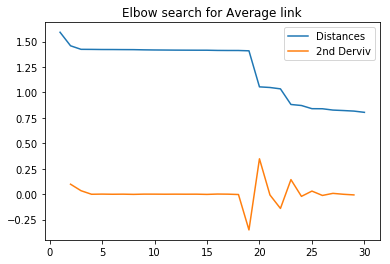

clusters: 18 at max_dist: 1.4127103762087345


In [27]:
k_single, maxDist_single = find_elbow(Z_single, title=title)

In [ ]:
plot_dendogram(Z_single, numClusters=int(k_single)+10, maxDist=maxDist_single-10**(-1), title=title)

In [ ]:
single_hc = AgglomerativeClustering(n_clusters=k_single, affinity='euclidean', linkage='single')
single_hc.fit(X_train)
silhouette_blob(X_train.values, single_hc.labels_, "Single Link")
labels_in_cluster(kmeans.labels_, nc, "Single Link")

### Complete Link

In [19]:
title = "Complete link"
Z_complete = linkage(X_train, 'complete')

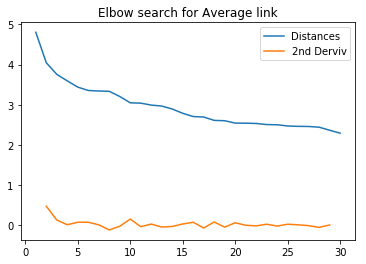

clusters: 8 at max_dist: 3.340226997228668


In [28]:
k_complete, maxDist_complete= find_elbow(Z_complete, title=title)

In [ ]:
plot_dendogram(Z_complete, numClusters=int(k_complete)+10, maxDist=maxDist_complete-10**(-1), title=title)

In [ ]:
complete_kMeans = KMeans(n_clusters=k_complete, random_state=42).fit(X_train)
labels_in_cluster(complete_kMeans.labels_, k_complete, title)

In [ ]:
silhouette_blob(X_train.values, complete_kMeans.labels_, complete_kMeans.cluster_centers_)

### Average Link

In [24]:
title = "Average link"
Z_average = linkage(X_train, 'average')

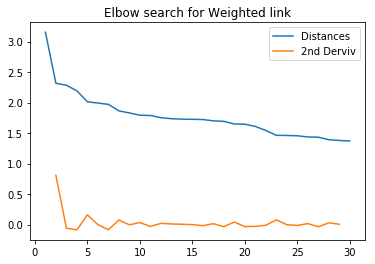

clusters: 23 at max_dist: 1.5421316000585787


In [36]:
k_average, maxDist_average= find_elbow(Z_average, 5, title=title)

In [ ]:
plot_dendogram(Z_average, numClusters=int(k_average)+10, maxDist=maxDist_average-5*10**(-2), title=title)

In [ ]:
average_kMeans = KMeans(n_clusters=k_average, random_state=42).fit(X_train)
labels_in_cluster(average_kMeans.labels_, k_average, title)

In [ ]:
silhouette_blob(X_train.values, average_kMeans.labels_, average_kMeans.cluster_centers_)

### Weighted Link

In [31]:
title = "Weighted link"
Z_weighted = linkage(X_train, 'weighted')

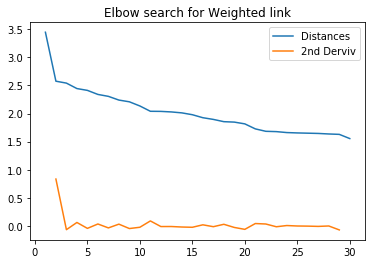

clusters: 21 at max_dist: 1.8158036647067894


In [35]:
k_weighted, maxDist_weighted= find_elbow(Z_weighted, 10, title=title)

In [ ]:
plot_dendogram(Z_weighted, numClusters=int(k_weighted)+10, maxDist=maxDist_weighted-5*10**(-2), title=title)

In [ ]:
weighted_kMeans = KMeans(n_clusters=k_weighted, random_state=42).fit(X_train)
labels_in_cluster(weighted_kMeans.labels_, k_weighted, title)

In [ ]:
silhouette_blob(X_train.values, weighted_kMeans.labels_, weighted_kMeans.cluster_centers_)

### Ward LInk

In [ ]:
title = "Ward link"
Z_ward = linkage(X_train, 'ward')

In [ ]:
k_ward, maxDist_ward= find_elbow(Z_ward, title=title)

In [ ]:
plot_dendogram(Z_ward, numClusters=int(k_ward)+10, maxDist=maxDist_ward-5, title=title)

In [ ]:
agg_with_kmeans(num_clusters=k_ward, title=title)

## Cure

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.cure import cure
from pyclustering.utils import read_sample

In [ ]:
# Allocate three clusters.
cure_instance = cure(X_train.values, 20);
cure_instance.process();
clusters = cure_instance.get_clusters();

In [ ]:
len(clusters[0])

In [ ]:
title = "CURE"
given_clusters = np.zeros(shape=(X_train.shape[0],))
for i, pts in enumerate(clusters):
    given_clusters[pts] = i

In [ ]:
labels_in_cluster(given_clusters, 20, title)

In [ ]:
silhouette_blob(X_train.values, given_clusters, np.array(cure_instance.get_means()))

# OG Dataset

In [ ]:
og_df = pd.read_csv('../../datasets/cleaned_soccer_data_2016_v2.csv')
og_df.columns

In [ ]:
og_pos = og_df['player_positions']
og_df = og_df.drop(["Unnamed: 0", "id", "player_fifa_api_id", "player_api_id", "date", "player_name", 'player_positions'], axis=1)
og_df

In [ ]:
for l in labels:
    og_df[l] = [0] * len(og_df)

for i, p in enumerate(og_pos.values):
    if ',' in p:
        split = p.split(', ')
        for s in split:
            og_df.loc[i, s] = 1
    else:
        og_df.loc[i, p] = 1
        
og_df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
og_scaled = min_max_scaler.fit_transform(og_df)

In [ ]:
np.random.shuffle(og_scaled)
samples = og_scaled[:5000]
len(samples)

In [ ]:
for nc in [4,6,8,10,11,12,14,16]:
    kmeans = KMeans(n_clusters=nc, random_state=42).fit(samples)
    silhouette_blob(samples, kmeans.labels_, kmeans.cluster_centers_)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(og_scaled)

In [ ]:
pca.explained_variance_ratio_